# Anaylizing NBA Game stats 2002-2019

In [595]:
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from scipy import stats # significance levels, normality
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings
import itertools # for combinations

from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower # for power testing


# REMAINING WORK:
* Explain why you used each type of t-test in each Hypothesis
* explaining and undertand what a T-stat, T-crit, P-Value, Effect size, Power are and what they mean for each
* clean up presentation of notebook

In [596]:
game_detail_df = pd.read_csv('Datasets/games_details.csv')
games_df = pd.read_csv('Datasets/games.csv')
players_df = pd.read_csv('Datasets/players.csv')
ranking_df = pd.read_csv('Datasets/ranking.csv')
teams_df = pd.read_csv('Datasets/teams.csv')

# EDA on our Data

### Inspecting game_detail_df

In [597]:
game_detail_df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,40800405,1610612747,LAL,Los Angeles,2772,Trevor Ariza,F,NaN,41:29,5.0,...,1.0,4.0,5.0,1.0,2.0,0.0,3.0,3.0,15.0,12.0
1,40800405,1610612747,LAL,Los Angeles,2200,Pau Gasol,F,NaN,42:09,6.0,...,4.0,11.0,15.0,3.0,0.0,4.0,1.0,2.0,14.0,15.0
2,40800405,1610612747,LAL,Los Angeles,101115,Andrew Bynum,C,NaN,16:54,3.0,...,4.0,1.0,5.0,0.0,1.0,0.0,1.0,5.0,6.0,-6.0
3,40800405,1610612747,LAL,Los Angeles,977,Kobe Bryant,G,NaN,43:18,10.0,...,0.0,6.0,6.0,5.0,2.0,4.0,1.0,2.0,30.0,14.0
4,40800405,1610612747,LAL,Los Angeles,965,Derek Fisher,G,NaN,31:59,4.0,...,0.0,4.0,4.0,2.0,0.0,0.0,1.0,4.0,13.0,16.0


In [598]:
game_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561733 entries, 0 to 561732
Data columns (total 28 columns):
GAME_ID              561733 non-null int64
TEAM_ID              561733 non-null int64
TEAM_ABBREVIATION    561733 non-null object
TEAM_CITY            561733 non-null object
PLAYER_ID            561733 non-null int64
PLAYER_NAME          561733 non-null object
START_POSITION       215354 non-null object
COMMENT              89924 non-null object
MIN                  471808 non-null object
FGM                  471808 non-null float64
FGA                  471808 non-null float64
FG_PCT               471808 non-null float64
FG3M                 471808 non-null float64
FG3A                 471808 non-null float64
FG3_PCT              471808 non-null float64
FTM                  471808 non-null float64
FTA                  471808 non-null float64
FT_PCT               471808 non-null float64
OREB                 471808 non-null float64
DREB                 471808 non-null float64
RE

Removing unnecessary Columns from our game_detail_df

In [599]:
game_detail_df.drop(columns=['COMMENT', 'PLUS_MINUS', 'START_POSITION'], inplace=True)

In [600]:
game_detail_df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,MIN,FGM,FGA,FG_PCT,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
0,40800405,1610612747,LAL,Los Angeles,2772,Trevor Ariza,41:29,5.0,12.0,0.417,...,0.5,1.0,4.0,5.0,1.0,2.0,0.0,3.0,3.0,15.0
1,40800405,1610612747,LAL,Los Angeles,2200,Pau Gasol,42:09,6.0,9.0,0.667,...,0.5,4.0,11.0,15.0,3.0,0.0,4.0,1.0,2.0,14.0
2,40800405,1610612747,LAL,Los Angeles,101115,Andrew Bynum,16:54,3.0,11.0,0.273,...,0.0,4.0,1.0,5.0,0.0,1.0,0.0,1.0,5.0,6.0
3,40800405,1610612747,LAL,Los Angeles,977,Kobe Bryant,43:18,10.0,23.0,0.435,...,1.0,0.0,6.0,6.0,5.0,2.0,4.0,1.0,2.0,30.0
4,40800405,1610612747,LAL,Los Angeles,965,Derek Fisher,31:59,4.0,7.0,0.571,...,1.0,0.0,4.0,4.0,2.0,0.0,0.0,1.0,4.0,13.0


In [601]:
# Create a new Column called DF_SCORE based on
game_detail_df["DF_SCORE"] = round((game_detail_df.PTS + game_detail_df.FG3M *0.5 + game_detail_df.REB *1.25 + game_detail_df.AST * 1.5 + game_detail_df.STL *2 + game_detail_df.BLK *2 - game_detail_df.TO * 0.5),2)

In [602]:
game_detail_df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,MIN,FGM,FGA,FG_PCT,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,DF_SCORE
0,40800405,1610612747,LAL,Los Angeles,2772,Trevor Ariza,41:29,5.0,12.0,0.417,...,1.0,4.0,5.0,1.0,2.0,0.0,3.0,3.0,15.0,26.25
1,40800405,1610612747,LAL,Los Angeles,2200,Pau Gasol,42:09,6.0,9.0,0.667,...,4.0,11.0,15.0,3.0,0.0,4.0,1.0,2.0,14.0,44.75
2,40800405,1610612747,LAL,Los Angeles,101115,Andrew Bynum,16:54,3.0,11.0,0.273,...,4.0,1.0,5.0,0.0,1.0,0.0,1.0,5.0,6.0,13.75
3,40800405,1610612747,LAL,Los Angeles,977,Kobe Bryant,43:18,10.0,23.0,0.435,...,0.0,6.0,6.0,5.0,2.0,4.0,1.0,2.0,30.0,57.50
4,40800405,1610612747,LAL,Los Angeles,965,Derek Fisher,31:59,4.0,7.0,0.571,...,0.0,4.0,4.0,2.0,0.0,0.0,1.0,4.0,13.0,21.00


In [603]:
game_detail_df.dropna(axis='rows', inplace=True)

In [604]:
game_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471808 entries, 0 to 561732
Data columns (total 26 columns):
GAME_ID              471808 non-null int64
TEAM_ID              471808 non-null int64
TEAM_ABBREVIATION    471808 non-null object
TEAM_CITY            471808 non-null object
PLAYER_ID            471808 non-null int64
PLAYER_NAME          471808 non-null object
MIN                  471808 non-null object
FGM                  471808 non-null float64
FGA                  471808 non-null float64
FG_PCT               471808 non-null float64
FG3M                 471808 non-null float64
FG3A                 471808 non-null float64
FG3_PCT              471808 non-null float64
FTM                  471808 non-null float64
FTA                  471808 non-null float64
FT_PCT               471808 non-null float64
OREB                 471808 non-null float64
DREB                 471808 non-null float64
REB                  471808 non-null float64
AST                  471808 non-null float64

In [605]:
#cleaning our column for our join and then Hypothesis
game_player_detail = game_detail_df[['GAME_ID', 'TEAM_ID','TEAM_CITY', 'TEAM_ABBREVIATION','MIN','PLAYER_ID', 'PLAYER_NAME', 'DF_SCORE']]
game_player_detail

,GAME_ID,TEAM_ID,TEAM_CITY,TEAM_ABBREVIATION,MIN,PLAYER_ID,PLAYER_NAME,DF_SCORE
0,40800405,1610612747,Los Angeles,LAL,41:29,2772,Trevor Ariza,26.25
1,40800405,1610612747,Los Angeles,LAL,42:09,2200,Pau Gasol,44.75
2,40800405,1610612747,Los Angeles,LAL,16:54,101115,Andrew Bynum,13.75
3,40800405,1610612747,Los Angeles,LAL,43:18,977,Kobe Bryant,57.50
4,40800405,1610612747,Los Angeles,LAL,31:59,965,Derek Fisher,21.00
5,40800405,1610612747,Los Angeles,LAL,31:44,1885,Lamar Odom,31.50
6,40800405,1610612747,Los Angeles,LAL,14:07,2575,Luke Walton,6.00
7,40800405,1610612747,Los Angeles,LAL,13:38,200770,Jordan Farmar,3.50
8,40800405,1610612747,Los Angeles,LAL,4:42,2756,Sasha Vujacic,0.00
12,40800405,1610612753,Orlando,ORL,42:05,2045,Hedo Turkoglu,20.50


### Inspecting game_df 

In [606]:
games_df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2014-06-15,41300405,Final,1610612759,1610612748,2013,1610612759,104.0,0.474,0.783,...,25.0,40.0,1610612748,87.0,0.400,0.741,0.280,14.0,41.0,1
1,2014-06-12,41300404,Final,1610612748,1610612759,2013,1610612748,86.0,0.451,0.650,...,13.0,27.0,1610612759,107.0,0.571,0.720,0.429,25.0,44.0,0
2,2014-06-10,41300403,Final,1610612748,1610612759,2013,1610612748,92.0,0.516,0.750,...,17.0,26.0,1610612759,111.0,0.594,0.813,0.450,21.0,29.0,0
3,2014-06-08,41300402,Final,1610612759,1610612748,2013,1610612759,96.0,0.439,0.600,...,26.0,37.0,1610612748,98.0,0.529,0.762,0.421,16.0,38.0,0
4,2014-06-05,41300401,Final,1610612759,1610612748,2013,1610612759,110.0,0.588,0.773,...,30.0,39.0,1610612748,95.0,0.474,0.818,0.414,16.0,29.0,1


In [607]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22594 entries, 0 to 22593
Data columns (total 21 columns):
GAME_DATE_EST       22594 non-null object
GAME_ID             22594 non-null int64
GAME_STATUS_TEXT    22594 non-null object
HOME_TEAM_ID        22594 non-null int64
VISITOR_TEAM_ID     22594 non-null int64
SEASON              22594 non-null int64
TEAM_ID_home        22594 non-null int64
PTS_home            22495 non-null float64
FG_PCT_home         22495 non-null float64
FT_PCT_home         22495 non-null float64
FG3_PCT_home        22495 non-null float64
AST_home            22495 non-null float64
REB_home            22495 non-null float64
TEAM_ID_away        22594 non-null int64
PTS_away            22495 non-null float64
FG_PCT_away         22495 non-null float64
FT_PCT_away         22495 non-null float64
FG3_PCT_away        22495 non-null float64
AST_away            22495 non-null float64
REB_away            22495 non-null float64
HOME_TEAM_WINS      22594 non-null int64
dtyp

In [608]:
# We are taking these specific columns, we will use them in order to test our first Hypothesis
game_hometeam_df = games_df[['GAME_ID','SEASON','GAME_DATE_EST', 'HOME_TEAM_ID', 'HOME_TEAM_WINS']]
game_hometeam_df.head()

,GAME_ID,SEASON,GAME_DATE_EST,HOME_TEAM_ID,HOME_TEAM_WINS
0,41300405,2013,2014-06-15,1610612759,1
1,41300404,2013,2014-06-12,1610612748,0
2,41300403,2013,2014-06-10,1610612748,0
3,41300402,2013,2014-06-08,1610612759,0
4,41300401,2013,2014-06-05,1610612759,1


In [609]:
# games_df.drop(columns=['GAME_STATUS_TEXT'], inplace=True)

In [610]:
# games_df.dropna(axis='rows', inplace=True)

In [611]:
#join both game_hometeam_df and game_player_detail
df2 = pd.merge(game_player_detail, game_hometeam_df, on='GAME_ID')
df2.head()

,GAME_ID,TEAM_ID,TEAM_CITY,TEAM_ABBREVIATION,MIN,PLAYER_ID,PLAYER_NAME,DF_SCORE,SEASON,GAME_DATE_EST,HOME_TEAM_ID,HOME_TEAM_WINS
0,40800405,1610612747,Los Angeles,LAL,41:29,2772,Trevor Ariza,26.25,2008,2009-06-14,1610612753,0
1,40800405,1610612747,Los Angeles,LAL,42:09,2200,Pau Gasol,44.75,2008,2009-06-14,1610612753,0
2,40800405,1610612747,Los Angeles,LAL,16:54,101115,Andrew Bynum,13.75,2008,2009-06-14,1610612753,0
3,40800405,1610612747,Los Angeles,LAL,43:18,977,Kobe Bryant,57.50,2008,2009-06-14,1610612753,0
4,40800405,1610612747,Los Angeles,LAL,31:59,965,Derek Fisher,21.00,2008,2009-06-14,1610612753,0


In [612]:
#just to make values in min to a float instead of a string
def minutes(value):
    list_nb = value.split(':')
    if len(list_nb) == 1:
        return float(list_nb[0])
    else:
        return round(float(list_nb[0]) + (float(list_nb[1])/60),2)
df2['MIN'] = df2['MIN'].apply(minutes)

In [613]:
df2.MIN.dtype

dtype('float64')

In [614]:
#creating a new column to see if the TEAM_ID == HOME_TEAM_ID to ensure they did play at home.
df2.loc[(df2['TEAM_ID'] == df2['HOME_TEAM_ID']), 'PLAYED_HOME'] = 1
df2.loc[(df2['TEAM_ID'] != df2['HOME_TEAM_ID']), 'PLAYED_HOME'] = 0

# using the previously made column to count win
df2.loc[(df2['PLAYED_HOME'] ==1), 'WIN'] = 1
df2.loc[(df2['PLAYED_HOME'] !=1), 'WIN'] = 0
df_MIN_ten = df2.loc[(df2['MIN'] > 10)]
df_MIN_ten.head()

,GAME_ID,TEAM_ID,TEAM_CITY,TEAM_ABBREVIATION,MIN,PLAYER_ID,PLAYER_NAME,DF_SCORE,SEASON,GAME_DATE_EST,HOME_TEAM_ID,HOME_TEAM_WINS,PLAYED_HOME,WIN
0,40800405,1610612747,Los Angeles,LAL,41.48,2772,Trevor Ariza,26.25,2008,2009-06-14,1610612753,0,0.0,0.0
1,40800405,1610612747,Los Angeles,LAL,42.15,2200,Pau Gasol,44.75,2008,2009-06-14,1610612753,0,0.0,0.0
2,40800405,1610612747,Los Angeles,LAL,16.90,101115,Andrew Bynum,13.75,2008,2009-06-14,1610612753,0,0.0,0.0
3,40800405,1610612747,Los Angeles,LAL,43.30,977,Kobe Bryant,57.50,2008,2009-06-14,1610612753,0,0.0,0.0
4,40800405,1610612747,Los Angeles,LAL,31.98,965,Derek Fisher,21.00,2008,2009-06-14,1610612753,0,0.0,0.0


In [615]:
# grouping players(who have multiple games) by the average of all of their scores
df_top_player_avg = df2.groupby('PLAYER_NAME')['DF_SCORE'].mean()
df_top_player_avg.sort_values(ascending=False)
# df_top_player_avg.head()
# df_top_player_avg.count()

#making a df with player scores and number of games they have played
df_top_player_count = df2.groupby('PLAYER_NAME')['DF_SCORE'].count()
df_top_player_count.sort_values(ascending=False)
frame = {'DF_AVG_SCORE': df_top_player_avg, 'GAMES_PLAYED': df_top_player_count}
df_top_player_stat = pd.DataFrame(frame)
df_top_player_stat.head(20)

#sorting the df to only show players who have avg score >10 and more games played then 250
df_top_player_stat = df_top_player_stat[(df_top_player_stat['DF_AVG_SCORE'] > 10) &
                                        (df_top_player_stat['GAMES_PLAYED'] > 250)]
list_players = df_top_player_stat.index
len(list_players) # 616 players that we want to use for our analysis
# list_players

616

In [616]:
df3 = df2.loc[(df2['PLAYER_NAME'].isin(list_players))]
df3_home = df3.loc[(df3['WIN'] == 1)]
df3_away = df3.loc[(df3['WIN'] == 0)]
df3_home.head()
df3_away.head()


,GAME_ID,TEAM_ID,TEAM_CITY,TEAM_ABBREVIATION,MIN,PLAYER_ID,PLAYER_NAME,DF_SCORE,SEASON,GAME_DATE_EST,HOME_TEAM_ID,HOME_TEAM_WINS,PLAYED_HOME,WIN
0,40800405,1610612747,Los Angeles,LAL,41.48,2772,Trevor Ariza,26.25,2008,2009-06-14,1610612753,0,0.0,0.0
1,40800405,1610612747,Los Angeles,LAL,42.15,2200,Pau Gasol,44.75,2008,2009-06-14,1610612753,0,0.0,0.0
2,40800405,1610612747,Los Angeles,LAL,16.90,101115,Andrew Bynum,13.75,2008,2009-06-14,1610612753,0,0.0,0.0
3,40800405,1610612747,Los Angeles,LAL,43.30,977,Kobe Bryant,57.50,2008,2009-06-14,1610612753,0,0.0,0.0
4,40800405,1610612747,Los Angeles,LAL,31.98,965,Derek Fisher,21.00,2008,2009-06-14,1610612753,0,0.0,0.0


In [617]:
df3_home_avg = df3_home.groupby('PLAYER_NAME')['DF_SCORE'].mean()
df3_away_avg = df3_away.groupby('PLAYER_NAME')['DF_SCORE'].mean()
frame = {'HOME_AVG': df3_home_avg, 'AWAY_AVG': df3_away_avg}
df3_home_away_stat = pd.DataFrame(frame)
df3_home_away_stat.head()
df3_home_away_stat['AVG_DIFFERENCE'] = ((df3_home_away_stat.HOME_AVG - df3_home_away_stat.AWAY_AVG))
df3_home_away_stat.head()
# df3_home_away_stat.AVG_DIFFERENCE.mean()

,HOME_AVG,AWAY_AVG,AVG_DIFFERENCE
PLAYER_NAME,,,
AJ Price,12.397651,11.822368,0.575283
Aaron Brooks,17.017717,17.426997,-0.409281
Aaron Gordon,26.473171,25.286486,1.186684
Adonal Foyle,12.828947,10.568182,2.260766
Al Harrington,26.987758,25.996250,0.991508


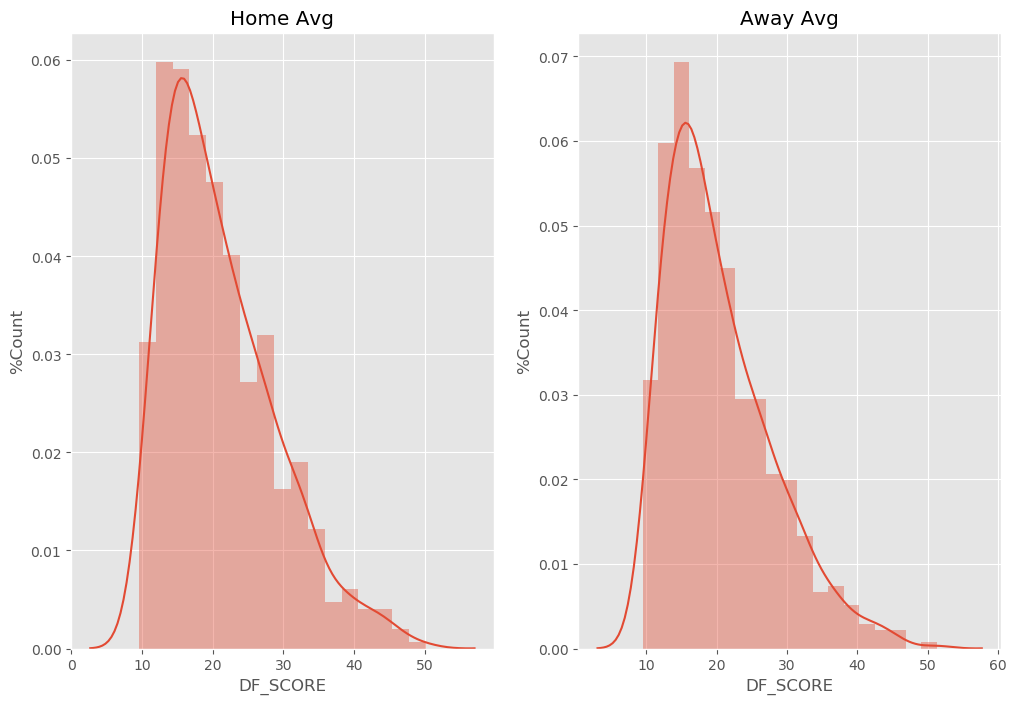

In [618]:
plt.figure(figsize=(12,8))
ax = plt.subplot(121)
plt.title('Home Avg')
plt.ylabel('%Count')
sns.distplot(df3_home_avg)

ax = plt.subplot(122)
plt.title('Away Avg')
plt.ylabel('%Count')
sns.distplot(df3_away_avg)

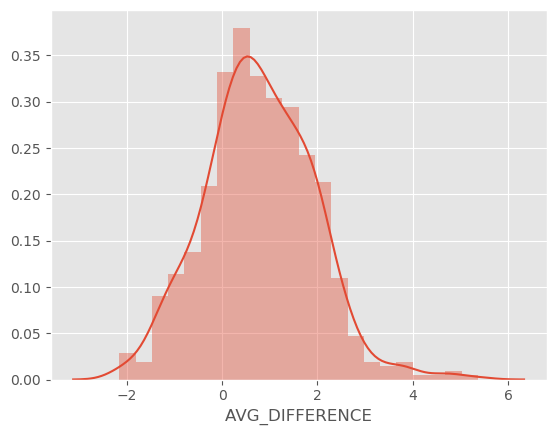

In [619]:
# average diff in players scores Home vs Away
sns.distplot(df3_home_away_stat.AVG_DIFFERENCE)

there is a very slight Average Difference in Player Performance Home vs Away but is it a Significant difference?

### Hypothesis1:
* $H_0$: There is no significant difference in player performance when playing Home vs Away
* $H_\alpha$: There is a significant difference in player performance when playing Home vs Away


In [620]:
# lets take Home_avg as our Control group and Away_avg as our experimental group
control = df3_home_avg
experimental = df3_away_avg

In [621]:
#Two sample Student's T-Test:
def two_sample_ttest(sample1, sample2, alpha):
    n_sample1 = len(sample1)
    n_sample2 = len(sample2)
    t_stat, P_value = stats.ttest_ind(sample1, sample2)
    t_crit = stats.t.ppf(1-(alpha/2), (n_sample1+n_sample2-2))
    mean_sample1 = round((sum(sample1)/n_sample1),3)
    mean_sample2 = round((sum(sample2)/n_sample2),3)
    mean_diff = round(abs(mean_sample1 - mean_sample2),3)
    
    #calculate Effect size and Power.
    cohen_d = Cohen_d(np.array(sample1), np.array(sample2))
    nobs = (n_sample1 + n_sample2)/2
    power = TTestIndPower()
    Power = power.solve_power(effect_size=cohen_d, 
                                              nobs1=nobs, 
                                              alpha=alpha, 
                                              ratio=(n_sample1/n_sample2),
                                              alternative='two-sided')

    # Outputs:
    print("Two Tail T-test:")
    print("---------------------------------------------------------------")
    print(f"Obs Number: Sample_1 = {n_sample1}   Sample_2 = {n_sample2}")
    print(f"Sample Means: Home Avg = {mean_sample1}   Away Avg = {mean_sample2}")
    print(f"Mean Differance: {mean_diff}")

    print("---------------------------------------------------------------")
    print(f'Cohen\'s d: {cohen_d}')
    print(f'Power: {Power}')
    print("---------------------------------------------------------------")
    print(f"t-crit: {t_crit} \nt-stat: {t_stat}")
    print("---------------------------------------------------------------")
    print(f'P-value: {P_value} \nAlpha(2-Tail): {alpha/2}')
    print("---------------------------------------------------------------")
    if (abs(t_stat) > t_crit) and (P_value < (alpha/2)):
        print("|t_stat| > t_crit:",(abs(t_stat) > t_crit))
        print("P_value > Alpha(2-Tail):", (P_value < alpha))
        print("\nReject Null Hypothesis! The results shows that the samples are statistically significant.")
    else:
        print("|t_stat| > t_crit:",(abs(t_stat) > t_crit))
        print("P_value < Alpha(2-Tail):", (P_value < (alpha/2)))
        print("\nDo NOT Reject Null Hypotheses. The results are NOT statistically significant.")
    print("---------------------------------------------------------------")
    return None

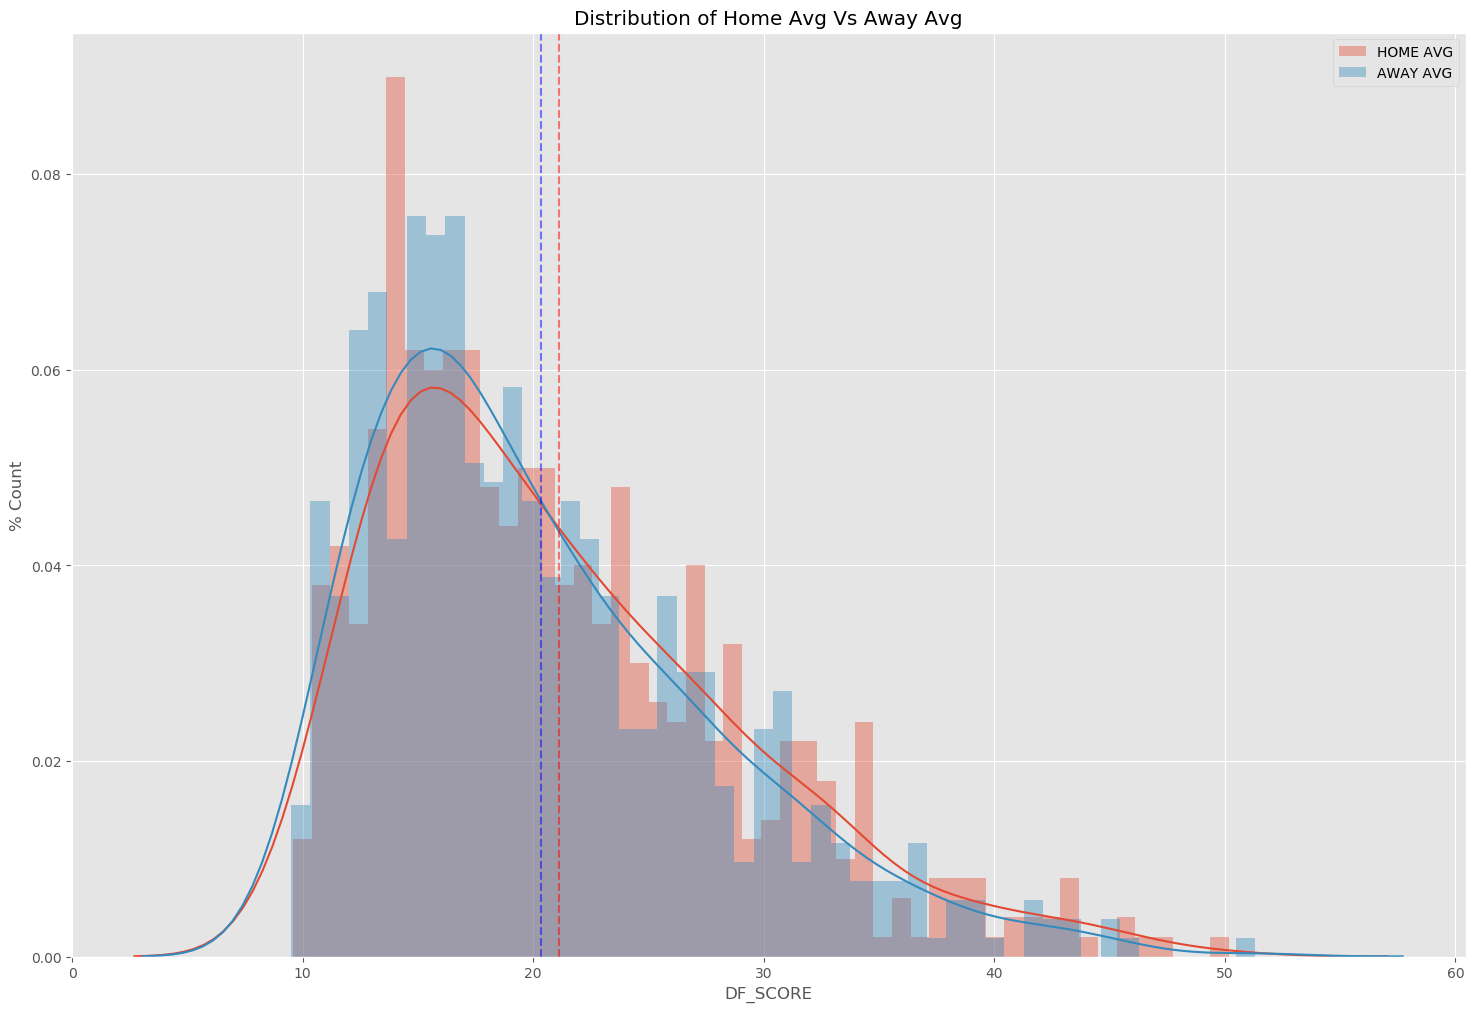

Two Tail T-test:
---------------------------------------------------------------
Obs Number: Sample_1 = 616   Sample_2 = 616
Sample Means: Home Avg = 21.125   Away Avg = 20.344
Mean Differance: 0.781
---------------------------------------------------------------
Cohen's d: 0.10236230106868754
Power: 0.434591881833695
---------------------------------------------------------------
t-crit: 1.9618945273326114 
t-stat: 1.7949923423579175
---------------------------------------------------------------
P-value: 0.0729003554467178 
Alpha(2-Tail): 0.025
---------------------------------------------------------------
|t_stat| > t_crit: False
P_value < Alpha(2-Tail): False

Do NOT Reject Null Hypotheses. The results are NOT statistically significant.
---------------------------------------------------------------


In [622]:
plt.figure(figsize=(18,12))
plt.title('Distribution of Home Avg Vs Away Avg')
sns.distplot(control, label='HOME AVG', bins=50)
sns.distplot(experimental, label='AWAY AVG',bins=50)
plt.ylabel('% Count')
plt.legend()
plt.axvline(x=control.mean(), color='r',alpha = 0.5, linestyle='--')
plt.axvline(x=experimental.mean(), color='b',alpha = 0.5, linestyle='--')
plt.show()
two_sample_ttest(control, experimental, 0.05)

From this we can see that the effect sizes is very low. We can also see that the P-Value is greater then our Alpha and our T-Stat is less then our critical value. this all leads us to believe that there is no Significant effect on player performance whether they play at home or away.

We may have been able to Reject our Null Hypothesis if we had a larger sample, and if we were to be more strict on certain variables, such as only sampling players with a better score, or even being more stingent on our condition such as more games played, or a min number of minutes played in the game, as it is hard to see the difference in players scores when some of the players have only played less then 10min. if they played less then 10min it is obv that their performance will be lower compared to games where they may have ended up playing longer games away.

# Hypothesis2:
* $H_0$: There is no significant difference in ease for teams to make the Playoffs in the East Vs the West
* $H_\alpha$: It is significantly easier for teams to make the Playoffs in the East Vs the West
$H_0$
$H_\alpha$


In [623]:
ranking_df.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD
0,1610612759,0,22013,2014-08-31,West,San Antonio,82,62,20,0.756,32-9,30-11
1,1610612760,0,22013,2014-08-31,West,Oklahoma City,82,59,23,0.720,34-7,25-16
2,1610612746,0,22013,2014-08-31,West,L.A. Clippers,82,57,25,0.695,34-7,23-18
3,1610612745,0,22013,2014-08-31,West,Houston,82,54,28,0.659,33-8,21-20
4,1610612757,0,22013,2014-08-31,West,Portland,82,54,28,0.659,31-10,23-18


In [624]:
seasons_ids = list(ranking_df["SEASON_ID"].unique())
seasons_df = []
for season_id in seasons_ids:
    n = str(season_id)[0]
    if n == "1":
        continue
    df = ranking_df[ranking_df["SEASON_ID"] == season_id]
    df = df.drop_duplicates(subset="TEAM")
    df["SEASON_ID"][:] = str(season_id)[1:]
    df = df.reset_index()
    df = df[["SEASON_ID", "CONFERENCE", "TEAM", "G", "W", "L", "W_PCT"]]    
    seasons_df.append(df)
seasons_df[-6]

,SEASON_ID,CONFERENCE,TEAM,G,W,L,W_PCT
0,2019,West,L.A. Lakers,20,17,3,0.850
1,2019,West,Denver,17,13,4,0.765
2,2019,West,LA Clippers,21,15,6,0.714
3,2019,West,Dallas,19,13,6,0.684
4,2019,West,Houston,19,13,6,0.684
5,2019,West,Utah,21,12,9,0.571
6,2019,West,Minnesota,19,10,9,0.526
7,2019,West,Phoenix,19,9,10,0.474
8,2019,West,Oklahoma City,19,8,11,0.421
9,2019,West,Sacramento,19,8,11,0.421


In [625]:
# we remove season 2019 as it is incomplete as of the time of collecting this Dataset.
del seasons_df[12] 

In [626]:
seasons_df[1]

,SEASON_ID,CONFERENCE,TEAM,G,W,L,W_PCT
0,2012,West,Oklahoma City,82,60,22,0.732
1,2012,West,San Antonio,82,58,24,0.707
2,2012,West,Denver,82,57,25,0.695
3,2012,West,L.A. Clippers,82,56,26,0.683
4,2012,West,Memphis,82,56,26,0.683
5,2012,West,Golden State,82,47,35,0.573
6,2012,West,Houston,82,45,37,0.549
7,2012,West,L.A. Lakers,82,45,37,0.549
8,2012,West,Utah,82,43,39,0.524
9,2012,West,Dallas,82,41,41,0.500


In [627]:
west_teams_qualifiying = []
east_teams_qualifiying = []
for season in seasons_df:
    west_qualifiying_min = round(float(season[7:8]['W_PCT'])*100,2)
    east_qualifiying_min = round(float(season[22:23]['W_PCT'])*100,2)
    west_teams_qualifiying.append(west_qualifiying_min)
    east_teams_qualifiying.append(east_qualifiying_min)

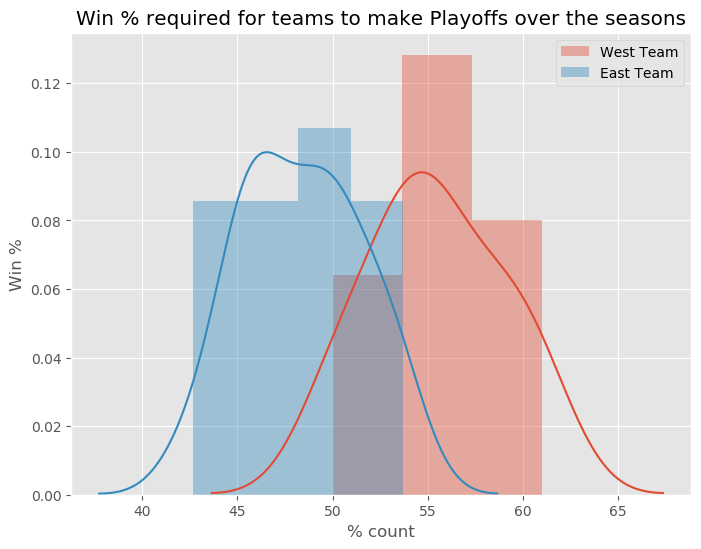

In [628]:
plt.figure(figsize=(8,6))
sns.distplot(west_teams_qualifiying, label='West Team')
sns.distplot(east_teams_qualifiying, label='East Team')
plt.xlabel('% count')
plt.ylabel('Win %')
plt.legend()
plt.title('Win % required for teams to make Playoffs over the seasons')
plt.show()

In [629]:
# West as control sample and East as Experimental sample.
control_2 = west_teams_qualifiying
experimental_2 = east_teams_qualifiying

In [631]:
#Two sample Student's T-Test:
def two_sample_ttest(sample1, sample2, alpha):
    n_sample1 = len(sample1)
    n_sample2 = len(sample2)
    t_stat, P_value = stats.ttest_ind(sample1, sample2)
    t_crit = stats.t.ppf(1-(alpha/2), (n_sample1+n_sample2-2))
    mean_sample1 = round((sum(sample1)/n_sample1),3)
    mean_sample2 = round((sum(sample2)/n_sample2),3)
    mean_diff = round(abs(mean_sample1 - mean_sample2),3)
    
    cohen_d = Cohen_d(np.array(sample1), np.array(sample2))
#     nobs = (n_sample1 + n_sample2)/2
#     power = TTestIndPower()
#     Power = power.solve_power(effect_size=cohen_d, 
#                                               nobs1=nobs, 
#                                               alpha=alpha, 
#                                               ratio=(n_sample1/n_sample2),
#                                               alternative='two-sided')
    # Outputs:
    print("Two Tail T-test:")
    print("---------------------------------------------------------------")
    print(f"Obs Number: Sample_1 = {n_sample1}   Sample_2 = {n_sample2}")
    print(f"Sample Means: West Teams Avg = {mean_sample1}   East Teams Avg = {mean_sample2}")
    print(f"Mean Differance: {mean_diff}")
#     sns.distplot(sample1), sns.distplot(sample2)
    print("---------------------------------------------------------------")
    print(f"t-crit: {t_crit} \nt-stat: {t_stat} \nP-value: {P_value} \nAlpha(2-Tail): {alpha/2}")
    print("---------------------------------------------------------------")
    print(f'Cohen\'s d: {cohen_d}')
#     print(f'Power: {Power}')
    print("---------------------------------------------------------------")
    if (abs(t_stat) > t_crit) and (P_value < (alpha/2)):
        print("|t_stat| > t_crit:",(abs(t_stat) > t_crit))
        print("P_value > Alpha(2-Tail):", (P_value < alpha))
        print("\nReject Null Hypothesis! The results shows that the samples are statistically significant.")
    else:
        print("|t_stat| > t_crit:",(abs(t_stat) > t_crit))
        print("P_value < Alpha(2-Tail):", (P_value < (alpha/2)))
        print("\nDo NOT Reject Null Hypotheses. The results are NOT statistically significant.")
    print("---------------------------------------------------------------")
    return None

Two Tail T-test:
---------------------------------------------------------------
Obs Number: Sample_1 = 17   Sample_2 = 17
Sample Means: West Teams Avg = 55.435   East Teams Avg = 48.376
Mean Differance: 7.059
---------------------------------------------------------------
t-crit: 2.036933343460101 
t-stat: 6.154645378955261 
P-value: 6.942372541866661e-07 
Alpha(2-Tail): 0.025
---------------------------------------------------------------
Cohen's d: 2.175995741628857
---------------------------------------------------------------
|t_stat| > t_crit: True
P_value > Alpha(2-Tail): True

Reject Null Hypothesis! The results shows that the samples are statistically significant.
---------------------------------------------------------------


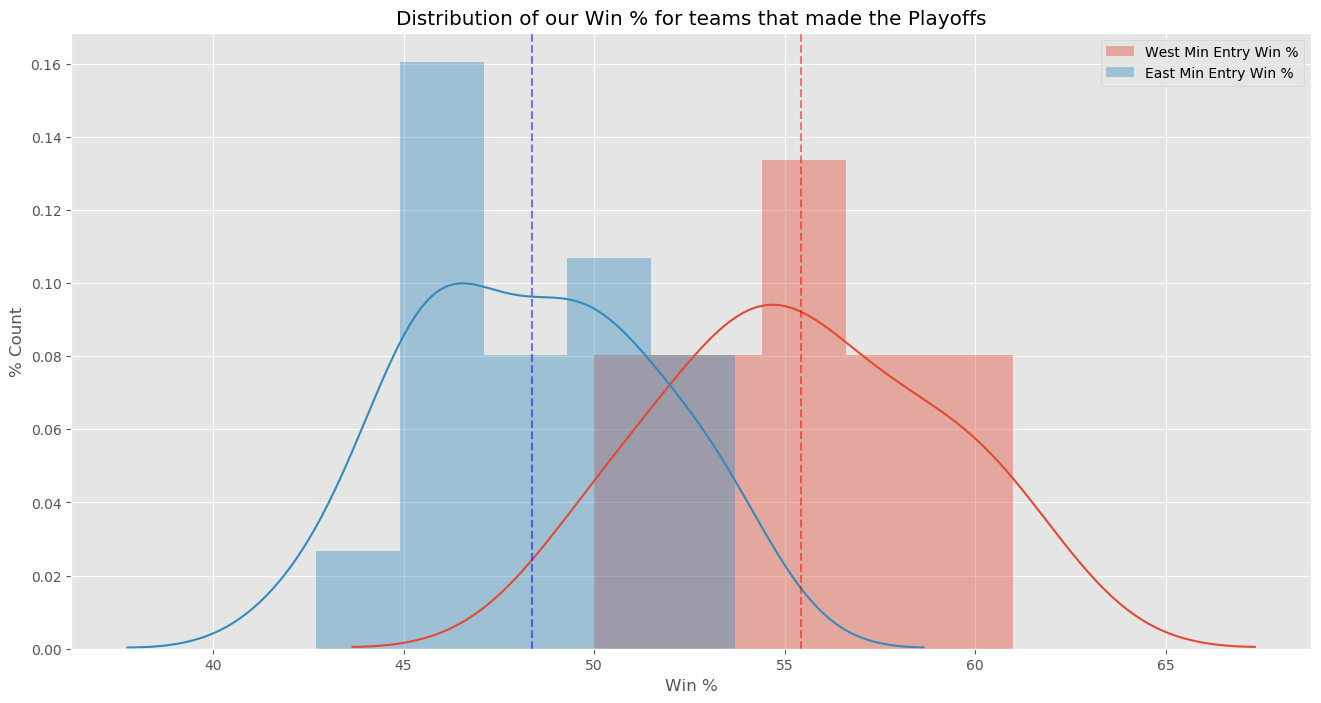

In [632]:
plt.figure(figsize=(16,8))
plt.title('Distribution of our Win % for teams that made the Playoffs')
sns.distplot(control_2, label='West Min Entry Win %', bins=5)
sns.distplot(experimental_2, label='East Min Entry Win %', bins=5)
plt.ylabel('% Count')
plt.xlabel('Win %')
plt.legend()
plt.axvline(x=np.array(control_2).mean(), color='r',alpha = 0.5, linestyle='--')
plt.axvline(x=np.array(experimental_2).mean(), color='b',alpha = 0.5, linestyle='--')
two_sample_ttest(control_2, experimental_2, 0.05)


We used a two tailed Student t-test as the samples were normally distributed.

<br>As you can see from the distribution it is very clear that  it is much more competitive and harder for teams in the West to make the playoffs as the minimum win % required by them is much higher compared to the East. the Avg score required to be of top 8 teams in west would require you to have at least an Avg win rate of 55%, that means winning more games then losing, while in the east the minimum Avg score to make the Playoffs is 48%, which shows that teams in the East make the Playoffs even though they have lost more games then won.

<br>Our P-Value is geater then Alpha and therefore it shows that there is a  statistically significant difference and thus we reject our Null Hypothesis, that there is no statistic significance in ease of making the Playoffs between teams in West vs East. 

<br>On top of that our Cohen d shows us that there is a large difference in the mean of both our sample distribution and the mean diff we calculate also further proves this.

### Hypothesis 3: 
* $H_0$: There is no significant difference in teams winning who have all stars players(with a DF_SCORE > 40 in their team)
* $H_\alpha$: There is a significant difference in teams winning who have all stars players(with a DF_SCORE > 40 in their team)


we have stated that players with an average score of 40 and greater would fall under the classifer of Allstar Player.

In [ ]:
df2_score_sorted = df2.set_index('DF_SCORE')
df2_score_sorted.sort_values('DF_SCORE',ascending=False)

In [ ]:
df2_grouped_season = df2.groupby(['SEASON','TEAM_CITY', 'PLAYER_NAME'])['DF_SCORE'].mean()
df2_grouped_season = df2_grouped_season.reset_index()
df2_grouped_season_2014 = df2_grouped_season[(df2_grouped_season['SEASON'] == 2014) &
                   (df2_grouped_season['DF_SCORE'] >= 40)]
df2_grouped_season_2014.TEAM_CITY.value_counts()
df2_grouped_season_2014

In [ ]:
#making two new lists, one with Teams with All stars and and team with no All stars with corrosponding stats
team_allstar_pct = []
team_non_allstar_pct = []
for season in seasons_df:
    year = int(season.SEASON_ID[0:1])
    allstars = df2_grouped_season[(df2_grouped_season['SEASON'] == year) & (df2_grouped_season['DF_SCORE'] > 40)]
    team_list = season.TEAM.unique()
    team_allstars_list = allstars.TEAM_CITY.value_counts().index
    for team in team_list:
        team_pct = float(season[(season['TEAM'] == team)]['W_PCT']*100)
        if team in team_allstars_list:
            team_allstar_pct.append(team_pct)
        else:
            team_non_allstar_pct.append(team_pct)

In [ ]:
team_allstar_pct = np.array(team_allstar_pct)

In [ ]:
team_non_allstar_pct = np.array(team_non_allstar_pct)

In [ ]:
def power(sample1,sample2, alpha):
    cohen_d = Cohen_d(np.array(sample1), np.array(sample2))
    n_sample1 = len(sample1)
    n_sample2 = len(sample2)
    nobs = (n_sample1 + n_sample2)/2
    a = TTestIndPower()
    Power = a.solve_power(effect_size=cohen_d, 
                                              nobs1=nobs, 
                                              alpha=alpha, 
                                              ratio=(n_sample1/n_sample2),
                                              alternative='two-sided')
    
power(team_allstar_pct, team_non_allstar_pct, 0.05)

In [ ]:
#finding Degrees of Freedom for two samples
def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    return numerator/denominator

t_stat , P_value = stats.ttest_ind(team_allstar_pct, team_non_allstar_pct, equal_var=False)
t_crit = stats.t.ppf(1-(0.05/2), (len(team_allstar_pct)+len(team_non_allstar_pct)-2))
df = welch_df(team_allstar_pct, team_non_allstar_pct)
cohen_d = Cohen_d(team_allstar_pct, team_non_allstar_pct)
# power = TTestIndPower()
# n_sample1 = len(team_allstar_pct)
# n_sample2 = len(team_non_allstar_pct)
# nobs = (n_sample1 + n_sample2)/2

# Power = power.solve_power(effect_size=cohen_d,nobs1=nobs, 
#                                               alpha=0.025, 
#                                               ratio=(n_sample1/n_sample2))

# Power

In [ ]:
# Outputs:
plt.figure(figsize=(12,8))
plt.title('Distribution of our Win% for teams with Allstars and team without any Allstars')
sns.distplot(team_allstar_pct, label ='Team with Allstar Win % Distribution', bins=25)
sns.distplot(team_non_allstar_pct,  label ='Team with No Allstar Win % Distribution',bins=25)
plt.axvline(np.array(team_allstar_pct).mean(), color='r',alpha = 0.7, linestyle='--')
plt.axvline(np.array(team_non_allstar_pct).mean(), color='b',alpha = 0.7, linestyle='--')

plt.ylabel('% Count')
plt.xlabel('Win %')

plt.legend()
# plt.axvline(x=experimental.mean(), color='b',alpha = 0.7, linestyle='--')
plt.show()
#output
print('Welch\'s T-test')
print('-----------------------------------------------------------------')
print(f'Average Allstar Win %: {round((np.array(team_allstar_pct).mean()),2)} % \n Standard Deviation of Allstar Win %: {round((np.array(team_allstar_pct).std()),2)} %')
print('-----------------------------------------------------------------')
print(f'Average Non-Allstar Win %: {round((np.array(team_non_allstar_pct).mean()),2)} % \n Standard Deviation of Non-Allstar Win %: {round((np.array(team_non_allstar_pct).std()),2)} %')
print('-----------------------------------------------------------------')
print(f"-Obs Number over all seasons-\n Team with Allstar = {len(team_allstar_pct)} \n Team with No Allstar = {len(team_non_allstar_pct)}")
print('-----------------------------------------------------------------')
print(f'Degrees of Freedom: {round(df)}')
print('-----------------------------------------------------------------')
print("T-Statistic:",abs(t_stat)) 
print('T-Critical value:', t_crit)
print('-----------------------------------------------------------------')
print('P-value:', P_value)
print()
print('Reject Null Hypothesis due to our p-value being less then 0.025') if p < 0.025 else print('Failed to reject Null Hypothesis')
print('Also as our T-Statistic > T-Critical value this again is evidence to reject our Null Hypothesis alongside our P-value' if stat_t> t_crit else print('Failed to reject Null Hypothesis'))
print('-----------------------------------------------------------------')
print(f"Cohen's d: {d}")
print("As it is greater then 0.5 this would indicate there is between a medium to large difference in mean between both samples")

# WHY WELCH T-test????

<br>As you can see the Average win % of teams that have Allstar players is around 10% higher then those teams that dont have any Allstar players. when we tested the 2 samples we used a Welch's T-test and our p-value was less then our Alpha(0.025 in this case since its a one tailed t-test) and thus we reject our Null Hypothesis as there is a significant difference in win % between teams with Allstar players vs team with no Allstar players 

In [ ]:
# Power is the probability of rejecting the null hypothesis when, in fact, it is false.
# Power is the probability of making a correct decision (to reject the null hypothesis) 
# when the null hypothesis is false. 
# Power is the probability that a test of significance will pick up on an effect that is present